In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
import pyro
import pyro.distributions as dist
from tqdm.auto import tqdm
from colorama import Fore, Style

import logging
logging.basicConfig(level=logging.INFO)

In [3]:
import sys
sys.path.append(".")
sys.path.append("scripts")
import rr_em

from berp.generators import thresholded_recognition_simple as generator
from berp.generators.response import simple_gaussian
from berp.generators.stimulus import Stimulus, RandomStimulusGenerator
from berp.models.reindexing_regression import ModelParameters, scatter_response_model
from berp.models.trf import TemporalReceptiveField, TRFDelayer

from berp.util import time_to_sample

## Generate synthetic data

In [106]:
# Establish parameters used to synthesize data
# Obviously these will not be used during inference!

coef_mean = torch.tensor([-1.])
params = ModelParameters(
    lambda_=pyro.deterministic("lambda", torch.tensor(1.0)),
    confusion=generator.phoneme_confusion,
    threshold=pyro.sample("threshold",
                          dist.Beta(1.2, 1.2)),

    # NB only used for generation, not in model
    a=pyro.deterministic("a", torch.tensor(0.2)),
    b=pyro.deterministic("b", torch.tensor(0.1)),
    coef=pyro.deterministic("coef", coef_mean),
    sigma=pyro.deterministic("sigma", torch.tensor(5.0)),
)

print(f"{Style.BRIGHT}Critical parameters:{Style.RESET_ALL}")
print("Threshold:\t", params.threshold.item())
print("Noise sigma:\t", params.sigma.item())

Critical parameters:
Threshold:	 0.08108454942703247
Noise sigma:	 5.0


In [110]:
epoch_window = (0.0, 0.55)
stim = RandomStimulusGenerator(num_words=1000, num_phonemes=10, phoneme_voc_size=params.confusion.shape[0],
                               word_surprisal_params=(2.0, 0.5))
ds_args = dict(response_type="gaussian", epoch_window=epoch_window, include_intercept=False, sample_rate=48)
dataset = generator.sample_dataset(params, stim, **ds_args)
test_dataset = generator.sample_dataset(params, stim, **ds_args)

### Visualize characteristic response

This is the shape of the word recognition response used in the data that we wish to infer:

Text(0.5, 1.0, 'Characteristic response in synthetic dataset')

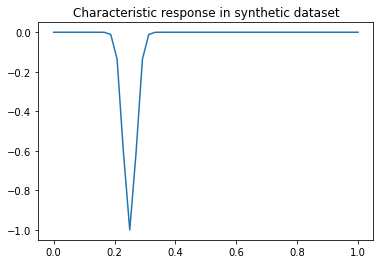

In [111]:
xs, ys = simple_gaussian(params.b, params.a, dataset.sample_rate)
ys = coef_mean[-1] * ys
plt.plot(xs, ys)

plt.title("Characteristic response in synthetic dataset")

### Visualize epoched data

In [112]:
# Epoch data.
epoch_tmin, epoch_tmax = torch.tensor(epoch_window)
epoch_samples = time_to_sample(epoch_tmax - epoch_tmin, dataset.sample_rate)
Y_epoch = torch.zeros((dataset.X_variable.shape[0], epoch_samples, dataset.Y.shape[-1]))
for i, word_onset in enumerate(dataset.word_onsets):
    word_onset_sample = time_to_sample(word_onset, dataset.sample_rate)
    word_offset_sample = word_onset_sample + epoch_samples
    Y_epoch[i, :, :] = dataset.Y[word_onset_sample:word_offset_sample, :]

Text(0.5, 0, 'Epoch time')

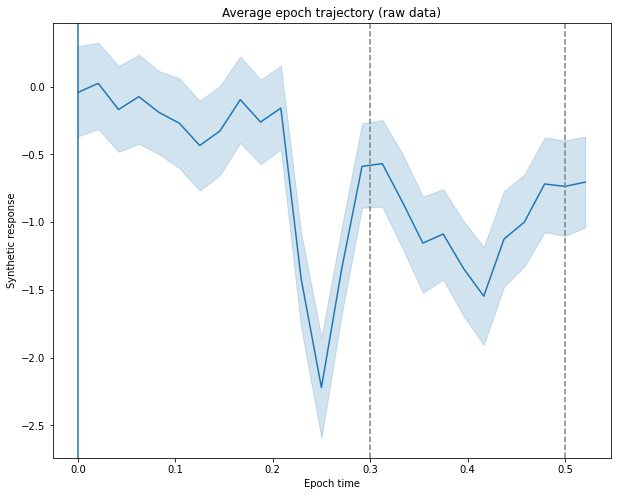

In [113]:
to_plot = pd.DataFrame(Y_epoch[:, :, 0])
to_plot.index.name = "epoch"
to_plot["surprisal"] = dataset.X_variable[:, -1]
to_plot = to_plot.melt(id_vars=["surprisal"], var_name="epoch_time")
to_plot["epoch_time"] /= dataset.sample_rate
to_plot["epoch_time"] += epoch_window[0]

plt.subplots(figsize=(10, 8))
sns.lineplot(data=to_plot, x="epoch_time", y="value")
plt.axvline(0.0)
plt.axvline(0.3, color="gray", linestyle="--")
plt.axvline(0.5, color="gray", linestyle="--")

plt.title("Average epoch trajectory (raw data)")
plt.ylabel("Synthetic response")
plt.xlabel("Epoch time")

Text(0.5, 0, 'Epoch time')

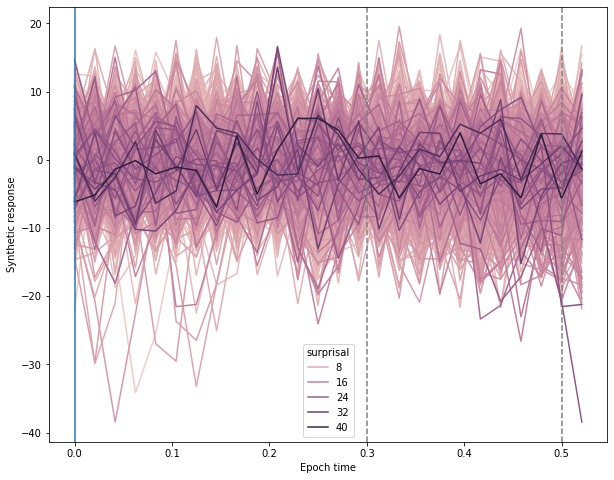

In [114]:
plt.subplots(figsize=(10, 8))
sns.lineplot(data=to_plot, x="epoch_time", y="value", hue="surprisal")
plt.axvline(0.0)
plt.axvline(0.3, color="gray", linestyle="--")
plt.axvline(0.5, color="gray", linestyle="--")

plt.ylabel("Synthetic response")
plt.xlabel("Epoch time")

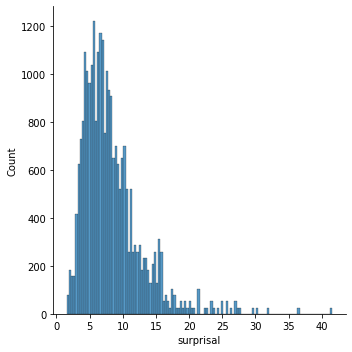

In [115]:
sns.displot(to_plot.surprisal)

## MLE regression

Raw visualization above doesn't produce a very clean EEG response. Let's try estimating a TRF model on the full data and see if we can recover something.

In [116]:
from sklearn.model_selection import ShuffleSplit

n_splits = 10
tmin, tmax = epoch_window
n_features = dataset.X_variable.shape[1] + dataset.X_ts.shape[1]
n_outputs = 1
encoder = TemporalReceptiveField(tmin, tmax, dataset.sample_rate,
                                 n_outputs=n_outputs,
                                 alpha=0)
coefs = torch.zeros((n_splits, n_features, len(encoder.delays_), n_outputs))

X_scatter = scatter_response_model(
    dataset.X_variable,
    dataset.X_ts,
    torch.zeros(dataset.X_variable.shape[0]).long(),
    dataset.phoneme_onsets + dataset.word_onsets.unsqueeze(1),
    sample_rate=dataset.sample_rate,
    total_samples=dataset.Y.shape[0])
X_del, _ = TRFDelayer(tmin, tmax, dataset.sample_rate).transform(X_scatter)

idxs = torch.arange(X_scatter.shape[0])

split_size = X_del.shape[0] // n_splits
split_offsets = torch.arange(n_splits) * split_size
for i_split, offset in enumerate(tqdm(split_offsets)):
    idxs_i = idxs[offset:offset + split_size]
    X_i = X_del[idxs_i]
    X_i[:, 1] += torch.randn(X_i[:, 1].shape)
    encoder_i = encoder.fit(X_del[idxs_i], dataset.Y[idxs_i])
    coefs[i_split] = encoder_i.coef_

  0%|          | 0/10 [00:00<?, ?it/s]

In [152]:
coef_df = pd.DataFrame(coefs[:, 1, :, 0])
coef_df.index.name = "fold"
coef_df = coef_df.reset_index().melt(id_vars=["fold"], var_name=["epoch_sample"])
coef_df["epoch_time"] = coef_df.epoch_sample / dataset.sample_rate
coef_df

,fold,epoch_sample,value,epoch_time
0,0,0,0.000000,0.0
1,1,0,0.000000,0.0
2,2,0,0.000000,0.0
3,3,0,0.000000,0.0
4,4,0,0.000000,0.0
...,...,...,...,...
265,5,26,0.000000,0.541667
266,6,26,0.041424,0.541667
267,7,26,0.000000,0.541667
268,8,26,0.000000,0.541667


Text(0.5, 0, 'Epoch time')

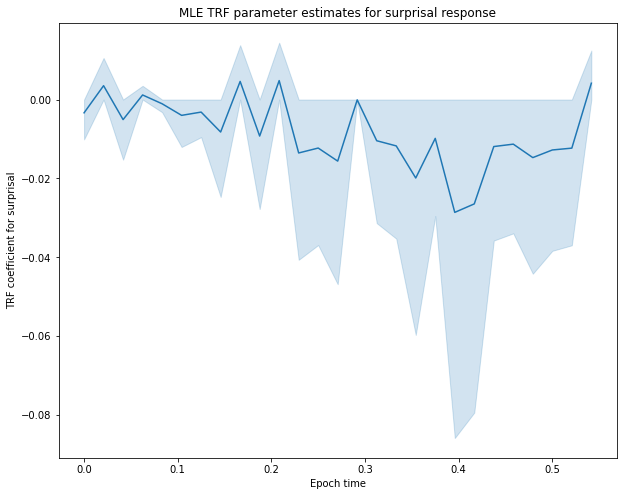

In [153]:
plt.subplots(figsize=(10, 8))
sns.lineplot(data=coef_df, x="epoch_time", y="value")

plt.title("MLE TRF parameter estimates for surprisal response")
plt.ylabel("TRF coefficient for surprisal")
plt.xlabel("Epoch time")

## Repro with new EM

In [119]:
from berp.datasets import NestedBerpDataset
from berp.models.trf_em import BerpTRFEM
from berp.solvers import AdamSolver
from optuna.distributions import UniformDistribution

In [120]:
# HACK
dataset.name = f"DKZ_1/{dataset.name}"
import importlib
import berp.models.trf_em
importlib.reload(berp.models.trf_em)

<module 'berp.models.trf_em' from '/net/vast-storage.ib.cluster/scratch/vast/cpl/jgauthie/scratch/bayesian-erp/berp/models/trf_em.py'>

In [121]:
em = BerpTRFEM(berp.models.trf.TemporalReceptiveField(tmin, tmax, dataset.sample_rate, dataset.n_sensors,
                                      optim=AdamSolver(early_stopping=False), alpha=1e-2),
               n_iter=1,
               latent_params={"threshold": {0: UniformDistribution(0., 1.)}},
               n_outputs=dataset.n_sensors, n_phonemes=len(dataset.phonemes))

{'n_iter': 1}


In [122]:
SINGLE_PARAM = em.pipeline.params[0]
SINGLE_PARAM.threshold

tensor([0.8522])

In [123]:
# HACK
em.pipeline.params = [SINGLE_PARAM]
em.pipeline.param_weights = torch.tensor([1.0])
em.param_resp_ = torch.tensor([1.0])

In [124]:
nested = NestedBerpDataset([dataset])

In [125]:
for _ in range(5):
    em.partial_fit(nested)
    print(em.param_resp_)

INFO:berp.models.trf_em:Priming pipeline for subject d4be842064c84115adec28fb72603842
INFO:berp.models.trf_em:Priming pipeline for dataset DKZ_1/d4be842064c84115adec28fb72603842
INFO:berp.models.trf_em:E-step finished


yay7 coef tensor([[[ 0.1927],
         [ 0.1487],
         [ 0.0901],
         [-0.2106],
         [ 0.0678],
         [-0.1235],
         [-0.0043],
         [-0.1605],
         [-0.0752],
         [ 0.1649],
         [-0.0392],
         [-0.1404],
         [-0.0728],
         [-0.0559],
         [-0.0769],
         [ 0.0762],
         [ 0.1642],
         [-0.0160],
         [-0.0497],
         [ 0.0440],
         [-0.0758],
         [ 0.1078],
         [ 0.0801],
         [ 0.1681],
         [ 0.1279],
         [ 0.1296],
         [ 0.0610]],

        [[ 0.1335],
         [-0.0232],
         [ 0.0042],
         [-0.0252],
         [ 0.0860],
         [-0.1385],
         [-0.0871],
         [-0.0223],
         [ 0.1717],
         [ 0.0319],
         [-0.0425],
         [-0.0814],
         [-0.0736],
         [-0.0837],
         [-0.0922],
         [ 0.1811],
         [ 0.0161],
         [ 0.0367],
         [ 0.0175],
         [-0.1185],
         [ 0.1384],
         [-0.1202],
        

INFO:berp.models.trf_em:M-step finished
INFO:berp.models.trf_em:Val score: 0.094394
INFO:berp.models.trf_em:E-step finished


tensor([1.])
X_orig2 tensor([[   53,     1,     0],
        [   54,     1,     1],
        [   55,     1,     2],
        ...,
        [42342,     1,    24],
        [42343,     1,    25],
        [42344,     1,    26]])
coef has -8753497827991233192
solver X train tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 5.2682, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
tensor([[53, 27],
        [54, 28],
        [55, 29],
        [56, 30],
        [57, 31],
        [58, 32],
        [59, 33],
        [60, 34],
        [61, 35],
        [62, 36],
        [63, 37],
        [64, 38],
        [65, 39],
        [66, 40],
 

INFO:berp.models.trf_em:M-step finished
INFO:berp.models.trf_em:Val score: 0.089827
INFO:berp.models.trf_em:E-step finished


X hashs -8925958185031734742
Y hash -3316613590601926390
Y_pred hash 4926415507340927832
argsort hash 3147100446180895020
tensor([1.])
X_orig2 tensor([[   53,     1,     0],
        [   54,     1,     1],
        [   55,     1,     2],
        ...,
        [42342,     1,    24],
        [42343,     1,    25],
        [42344,     1,    26]])
coef has -6644214454873602895
solver X train tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 5.2682, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
tensor([[53, 27],
        [54, 28],
        [55, 29],
        [56, 30],
        [57, 31],
        [58, 32],
        [59, 33],
     

INFO:berp.models.trf_em:M-step finished
INFO:berp.models.trf_em:Val score: 0.089825
INFO:berp.models.trf_em:E-step finished


X hashs -8925958185031734742
Y hash -3316613590601926390
Y_pred hash -4365015904616136662
argsort hash -3734788991261089930
tensor([1.])
X_orig2 tensor([[   53,     1,     0],
        [   54,     1,     1],
        [   55,     1,     2],
        ...,
        [42342,     1,    24],
        [42343,     1,    25],
        [42344,     1,    26]])
coef has -6644214454873602895
solver X train tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 5.2682, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
tensor([[53, 27],
        [54, 28],
        [55, 29],
        [56, 30],
        [57, 31],
        [58, 32],
        [59, 33],
   

INFO:berp.models.trf_em:M-step finished
INFO:berp.models.trf_em:Val score: 0.089825
INFO:berp.models.trf_em:E-step finished


tensor(0.0100)
optim/loss tensor(27.3075)
shape torch.Size([2, 27, 1])
X hashs -8925958185031734742
Y hash -3316613590601926390
Y_pred hash -4365015904616136662
argsort hash -3734788991261089930
tensor([1.])
X_orig2 tensor([[   53,     1,     0],
        [   54,     1,     1],
        [   55,     1,     2],
        ...,
        [42342,     1,    24],
        [42343,     1,    25],
        [42344,     1,    26]])
coef has -6644214454873602895
solver X train tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 5.2682, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
tensor([[53, 27],
        [54, 28],
        [55, 29],
    

INFO:berp.models.trf_em:M-step finished
INFO:berp.models.trf_em:Val score: 0.089825


tensor(0.0100)
optim/loss tensor(26.1118)
batch size 512 tensor(34816) torch.Size([42383, 54]) torch.Size([512, 54])
optim/batch_X 5354161859494280532
optim/batch_y -7075817058411082838
loss/Y_pred 7512132319300594833
loss/alpha tensor(0.0100)
optim/loss tensor(29.6146)
batch size 512 tensor(35328) torch.Size([42383, 54]) torch.Size([512, 54])
optim/batch_X -1368514389556514039
optim/batch_y 6643157780752934655
loss/Y_pred -58700461133589854
loss/alpha tensor(0.0100)
optim/loss tensor(27.0192)
batch size 512 tensor(35840) torch.Size([42383, 54]) torch.Size([512, 54])
optim/batch_X 6167347230735763714
optim/batch_y 1227598157500963625
loss/Y_pred 9003566466489576917
loss/alpha tensor(0.0100)
optim/loss tensor(27.8318)
batch size 512 tensor(36352) torch.Size([42383, 54]) torch.Size([512, 54])
optim/batch_X 5430449617987853199
optim/batch_y 1296770089983342426
loss/Y_pred 7388999739360274858
loss/alpha tensor(0.0100)
optim/loss tensor(28.9121)
batch size 512 tensor(36864) torch.Size([4238

In [126]:
em.pipeline.params[0].threshold

tensor([0.8522])

In [156]:
coef_df2 = pd.DataFrame(next(iter(em.pipeline.pipelines_.values())).encoder.coef_.unsqueeze(0)[:, 1, :, 0])
coef_df2.index.name = "iter"
coef_df2 = coef_df2.reset_index().melt(id_vars=["iter"], var_name=["epoch_sample"])
coef_df2["epoch_time"] = coef_df2.epoch_sample / dataset.sample_rate
coef_df2

,iter,epoch_sample,value,epoch_time
0,0,0,0.030118,0.0
1,0,1,0.020516,0.020833
2,0,2,-0.047167,0.041667
3,0,3,-0.033823,0.0625
4,0,4,-0.018762,0.083333
5,0,5,0.003505,0.104167
6,0,6,-0.020418,0.125
7,0,7,-0.032345,0.145833
8,0,8,-0.034861,0.166667
9,0,9,0.069021,0.1875


Text(0.5, 0, 'Epoch time')

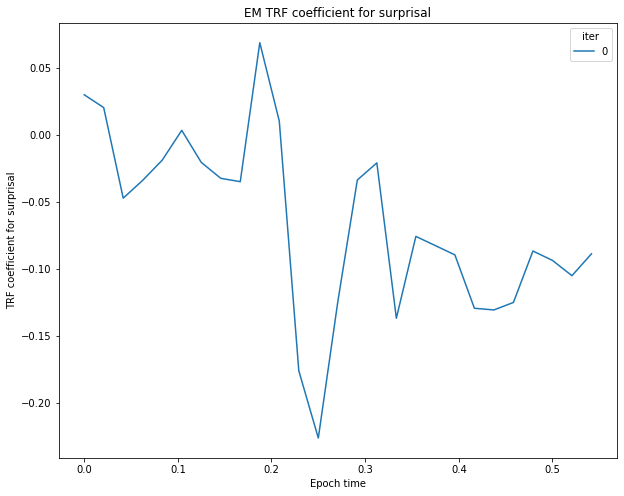

In [157]:
plt.subplots(figsize=(10, 8))
sns.lineplot(data=coef_df2, x="epoch_time", y="value", hue="iter")

plt.title("EM TRF coefficient for surprisal")
plt.ylabel("TRF coefficient for surprisal")
plt.xlabel("Epoch time")

In [158]:
em.param_resp_

tensor([1.])

In [130]:
sum([weight * params.threshold for weight, params in zip(em.pipeline.param_weights, em.pipeline.params)])

tensor([0.8522])

In [131]:
em.get_params()

{'early_stopping': 1,
 'n_iter': 1,
 'pipeline__encoder__alpha': 0.01,
 'pipeline__encoder__fit_intercept': False,
 'pipeline__encoder__n_outputs': 1,
 'pipeline__encoder__optim__batch_size': 512,
 'pipeline__encoder__optim__early_stopping': False,
 'pipeline__encoder__optim__learning_rate': 0.01,
 'pipeline__encoder__optim__n_epochs': 1,
 'pipeline__encoder__optim__pbar': False,
 'pipeline__encoder__optim__random_state': None,
 'pipeline__encoder__optim': AdamSolver(early_stopping=False),
 'pipeline__encoder__sfreq': 48,
 'pipeline__encoder__tmax': 0.55,
 'pipeline__encoder__tmin': 0.0,
 'pipeline__encoder__warm_start': True,
 'pipeline__encoder': TemporalReceptiveField(alpha=0.01, n_outputs=1,
                        optim=AdamSolver(early_stopping=False), sfreq=48,
                        tmax=0.55, tmin=0.0),
 'pipeline__param_weights': tensor([1.]),
 'pipeline__params': [ModelParameters(lambda_=tensor(1.), confusion=tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

## EM regression with latent recognition

In [132]:
import importlib
import berp.models.trf
importlib.reload(berp.models.trf)
importlib.reload(rr_em)

<module 'rr_em' from '/net/vast-storage.ib.cluster/scratch/vast/cpl/jgauthie/scratch/bayesian-erp/scripts/rr_em.py'>

In [133]:
# param_grid = [rr_em.get_parameters() for _ in range(50)]
# HACK pull from later pipeline to try to reproduce
param_grid = [SINGLE_PARAM]

In [134]:
# SINGLE_PARAM

In [135]:
weights, encoders = rr_em.fit_em(dataset, param_grid, test_dataset, n_iter=5, trf_alpha=1e-2,
                                 epoch_window=(tmin, tmax), solver="sgd",
                                 early_stopping_patience=3)

{'alpha': 0.01, 'fit_intercept': False, 'n_outputs': 1, 'optim__batch_size': 512, 'optim__early_stopping': None, 'optim__learning_rate': 0.01, 'optim__n_epochs': 1, 'optim__pbar': False, 'optim__random_state': None, 'optim': AdamSolver(early_stopping=None), 'sfreq': 48, 'tmax': 0.55, 'tmin': 0.0, 'warm_start': True}
{'sfreq': 48, 'tmax': 0.55, 'tmin': 0.0}


  0%|          | 0/5 [00:00<?, ?it/s]

yay7 coef tensor([[[ 0.1927],
         [ 0.1487],
         [ 0.0901],
         [-0.2106],
         [ 0.0678],
         [-0.1235],
         [-0.0043],
         [-0.1605],
         [-0.0752],
         [ 0.1649],
         [-0.0392],
         [-0.1404],
         [-0.0728],
         [-0.0559],
         [-0.0769],
         [ 0.0762],
         [ 0.1642],
         [-0.0160],
         [-0.0497],
         [ 0.0440],
         [-0.0758],
         [ 0.1078],
         [ 0.0801],
         [ 0.1681],
         [ 0.1279],
         [ 0.1296],
         [ 0.0610]],

        [[ 0.1335],
         [-0.0232],
         [ 0.0042],
         [-0.0252],
         [ 0.0860],
         [-0.1385],
         [-0.0871],
         [-0.0223],
         [ 0.1717],
         [ 0.0319],
         [-0.0425],
         [-0.0814],
         [-0.0736],
         [-0.0837],
         [-0.0922],
         [ 0.1811],
         [ 0.0161],
         [ 0.0367],
         [ 0.0175],
         [-0.1185],
         [ 0.1384],
         [-0.1202],
        

In [154]:
coef_df = pd.DataFrame(torch.stack(encoders[1:])[:, 1, :, 0])
coef_df.index.name = "iter"
coef_df = coef_df.reset_index().melt(id_vars=["iter"], var_name=["epoch_sample"])
coef_df["epoch_time"] = coef_df.epoch_sample / dataset.sample_rate
coef_df

,iter,epoch_sample,value,epoch_time
0,0,0,0.030333,0.0
1,1,0,0.030118,0.0
2,2,0,0.030118,0.0
3,3,0,0.030118,0.0
4,0,1,0.038842,0.020833
...,...,...,...,...
103,3,25,-0.105103,0.520833
104,0,26,-0.086900,0.541667
105,1,26,-0.088777,0.541667
106,2,26,-0.088777,0.541667


Text(0.5, 0, 'Epoch time')

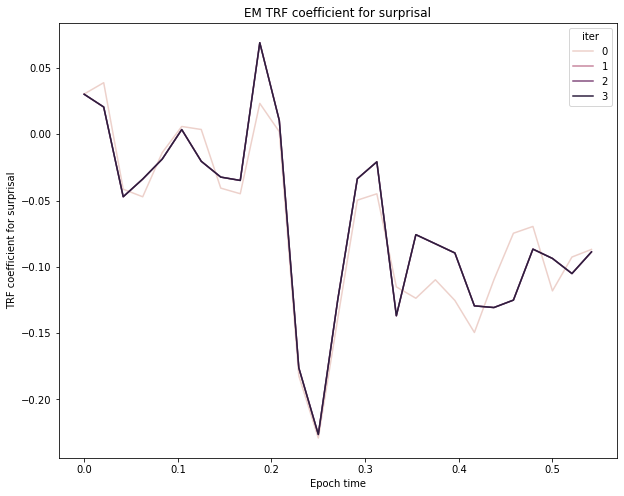

In [155]:
plt.subplots(figsize=(10, 8))
sns.lineplot(data=coef_df, x="epoch_time", y="value", hue="iter")

plt.title("EM TRF coefficient for surprisal")
plt.ylabel("TRF coefficient for surprisal")
plt.xlabel("Epoch time")

Text(0.5, 1.0, 'Distribution over weight grid, averaged over iterations')

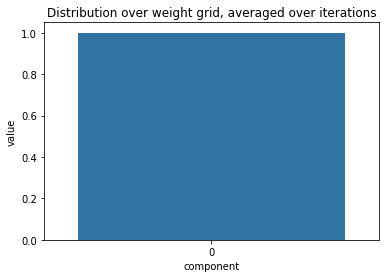

In [138]:
weight_df = pd.DataFrame(weights)
weight_df.index.name = "iter"
to_plot = weight_df.reset_index().melt(id_vars=["iter"], var_name="component")

# sns.FacetGrid(data=to_plot, row="iter").map(sns.barplot, "component", "value")
sns.barplot(data=to_plot, x="component", y="value")

plt.title("Distribution over weight grid, averaged over iterations")

In [139]:
weights.numpy().round(3)

array([[1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [140]:
thresholds = {k: params.threshold.numpy() for k, params in enumerate(param_grid)}
to_plot["threshold"] = to_plot.component.map(thresholds)

In [141]:
to_plot.groupby("iter").apply(lambda xs: (xs.value * xs.threshold).sum())

iter
0    [0.85221636]
1    [0.85221636]
2    [0.85221636]
3    [0.85221636]
dtype: object

/home/jgauthie/om2/miniconda/envs/berp/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/jgauthie/om2/miniconda/envs/berp/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


<AxesSubplot:ylabel='Density'>

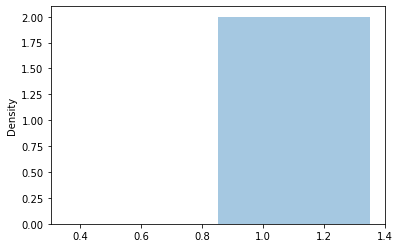

In [142]:
sns.distplot(to_plot.groupby("iter").apply(lambda xs: (xs.value * xs.threshold).sum()))

In [143]:
params.threshold

tensor(0.0811)

In [144]:
coef_df[coef_df.iter == 0]

,iter,epoch_sample,value,epoch_time
0,0,0,-0.002329,0.0
4,0,1,0.001192,0.020833
8,0,2,0.000306,0.041667
12,0,3,0.001131,0.0625
16,0,4,-0.000528,0.083333
20,0,5,-0.000384,0.104167
24,0,6,-0.000055,0.125
28,0,7,0.000041,0.145833
32,0,8,-0.000325,0.166667
36,0,9,-0.000583,0.1875


In [145]:
coef_df2

,iter,epoch_sample,value,epoch_time
0,0,0,-0.002356,0.0
1,0,1,0.002813,0.020833
2,0,2,0.002329,0.041667
3,0,3,0.003964,0.0625
4,0,4,-0.001602,0.083333
5,0,5,0.002194,0.104167
6,0,6,0.000019,0.125
7,0,7,-0.003015,0.145833
8,0,8,0.001518,0.166667
9,0,9,0.002596,0.1875
